In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, median_absolute_error, mean_absolute_error

In [2]:
import statsmodels.api as sm
data = sm.datasets.co2.load_pandas().data

In [3]:
data.head(5)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


<Axes: >

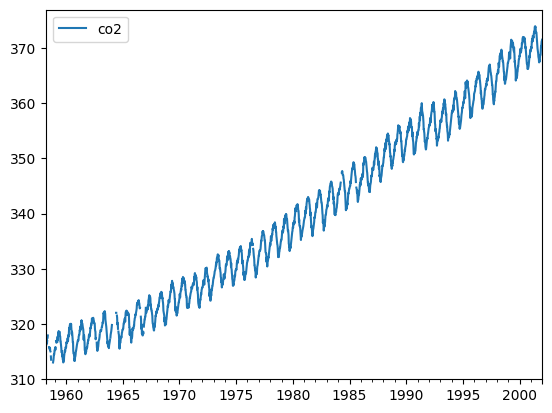

In [5]:
fig, ax = plt.subplots()
data.plot(ax=ax)

<Axes: >

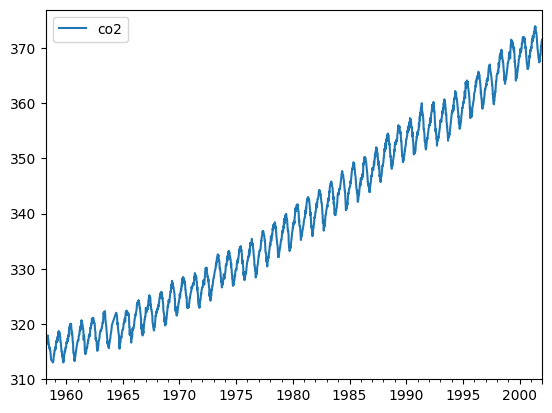

In [6]:
fig, ax = plt.subplots()
data = data.interpolate(method='linear')
data.plot(ax=ax)


In [7]:
def timeseries_to_hankel(data: pd.DataFrame,
                         n_input: int,
                         n_output: int,
                         target_col_name: str) -> pd.DataFrame:
    """
    Transforms timeseries to the Hankel-like matrix format
    :param data: data frame with data. Uniform timesteps are expected
    :param n_input: number of values in the past to rely on
    :param n_output: forecasting horizon
    :param target_col_name: name of the columns with target data
    :return:
    """
    # https://en.wikipedia.org/wiki/Hankel_matrix
    df = data.copy()

    i = 1
    while i < n_input:
        df[f'x_{i}'] = df[target_col_name].shift(i)
        i = i + 1

    j = 0
    while j < n_output:
        df[f'y_{j}'] = df[target_col_name].shift(-n_input+2-j)
        j = j + 1

    df = df.dropna(axis=0)
    df.rename(columns={target_col_name: 'x_0'}, inplace=True)

    return df

In [8]:
n_input = 3
n_output = 2
data_for_forecast = timeseries_to_hankel(data=data,
                                         n_input=n_input,
                                         n_output=n_output,
                                         target_col_name='co2')
columns_x = [f"x_{i}" for i in range(n_input-1, -1, -1)]
columns_y = [f"y_{i}" for i in range(n_output)]
data_for_forecast[columns_x+columns_y].head()

,x_2,x_1,x_0,y_0,y_1
1958-04-12,316.1,317.3,317.6,317.5,316.4
1958-04-19,317.3,317.6,317.5,316.4,316.9
1958-04-26,317.6,317.5,316.4,316.9,317.2
1958-05-03,317.5,316.4,316.9,317.2,317.5
1958-05-10,316.4,316.9,317.2,317.5,317.9


In [9]:
from random import choices
class RandomRegressor():
  """
  Random regressor class. It predicts y values from a set of given X values.
  """
  def __init__(self):
    pass

  def fit(self, X, y):
    self.forecast_shape = y.shape


  def predict(self, X):
    if isinstance(X, np.ndarray):
      list_to_select_from = X.reshape(-1).tolist()
    elif isinstance(X, pd.DataFrame):
      list_to_select_from = X.values.reshape(-1).tolist()
    else:
      raise TypeError("Unsupported datatype")
    forecast = choices(list_to_select_from, k=np.product(self.forecast_shape))

    forecast_array = np.array(forecast).reshape(self.forecast_shape)

    return forecast_array

In [10]:
rr = RandomRegressor()
rr.fit(None, np.zeros(3))
rr.predict(np.array([3, 4, 1, 8, 0, 5]))

array([5, 8, 0])

In [11]:
def get_class_name(x):
    """
    Returns name of class instance
    """
    return x.__class__.__name__

In [12]:
n_input = 5 # число точек для калибровки модели
n_output = 4 # горизонт прогнозирования
metric_funcs = [mean_absolute_percentage_error, median_absolute_error]

columns_x = [f"x_{i}" for i in range(n_input-1, -1, -1)]
columns_y = [f"y_{i}" for i in range(n_output)]

tscv = TimeSeriesSplit(max_train_size=20, test_size=20, n_splits=50)

backtesting_results = []
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    data_train_hankel = timeseries_to_hankel(data=data.iloc[train_index],
                                             n_input=n_input,
                                             n_output=n_output,
                                             target_col_name='co2')
    data_test_hankel = timeseries_to_hankel(data=data.iloc[test_index],
                                            n_input=n_input,
                                            n_output=n_output,
                                            target_col_name='co2')

    X_train = data_train_hankel[columns_x]
    y_train = data_train_hankel[columns_y]
    X_test = data_test_hankel[columns_x]
    y_test = data_test_hankel[columns_y]
    for regressor in [RandomRegressor, DecisionTreeRegressor, LinearRegression]:
        if regressor == RandomRegressor:
            reg = regressor()
        else:
            reg = regressor()
        reg.fit(X=X_train, y=y_train)
        prediction = reg.predict(X_test)
        prediction_df = pd.DataFrame(prediction, columns=columns_y, index=X_test.index)
        for mf in metric_funcs:
            for c in columns_y:
                metric_value = mf(y_pred=prediction_df[c],y_true=y_test[c])
                backtesting_results.append({"metric_name": mf.__name__,
                                            "metric_value": metric_value,
                                            "variable": c,
                                            "regressor": get_class_name(reg),
                                            "backtesting_index": i})

In [13]:
data_test_hankel

,x_0,x_1,x_2,x_3,x_4,y_0,y_1,y_2,y_3
2001-09-15,368.0,368.2,368.4,369.0,369.3,367.8,367.6,368.1,368.7
2001-09-22,367.4,368.0,368.2,368.4,369.0,367.6,368.1,368.7,368.7
2001-09-29,367.4,367.4,368.0,368.2,368.4,368.1,368.7,368.7,368.8
2001-10-06,367.8,367.4,367.4,368.0,368.2,368.7,368.7,368.8,369.7
2001-10-13,367.6,367.8,367.4,367.4,368.0,368.7,368.8,369.7,370.3
2001-10-20,368.1,367.6,367.8,367.4,367.4,368.8,369.7,370.3,370.3
2001-10-27,368.7,368.1,367.6,367.8,367.4,369.7,370.3,370.3,370.8
2001-11-03,368.7,368.7,368.1,367.6,367.8,370.3,370.3,370.8,371.2
2001-11-10,368.8,368.7,368.7,368.1,367.6,370.3,370.8,371.2,371.3
2001-11-17,369.7,368.8,368.7,368.7,368.1,370.8,371.2,371.3,371.5


In [14]:
pd.DataFrame(backtesting_results)

,metric_name,metric_value,variable,regressor,backtesting_index
0,mean_absolute_percentage_error,0.004474,y_0,RandomRegressor,0
1,mean_absolute_percentage_error,0.003157,y_1,RandomRegressor,0
2,mean_absolute_percentage_error,0.005318,y_2,RandomRegressor,0
3,mean_absolute_percentage_error,0.004932,y_3,RandomRegressor,0
4,median_absolute_error,1.100000,y_0,RandomRegressor,0
...,...,...,...,...,...
1195,mean_absolute_percentage_error,0.013071,y_3,LinearRegression,49
1196,median_absolute_error,5.073794,y_0,LinearRegression,49
1197,median_absolute_error,5.756404,y_1,LinearRegression,49
1198,median_absolute_error,5.942778,y_2,LinearRegression,49


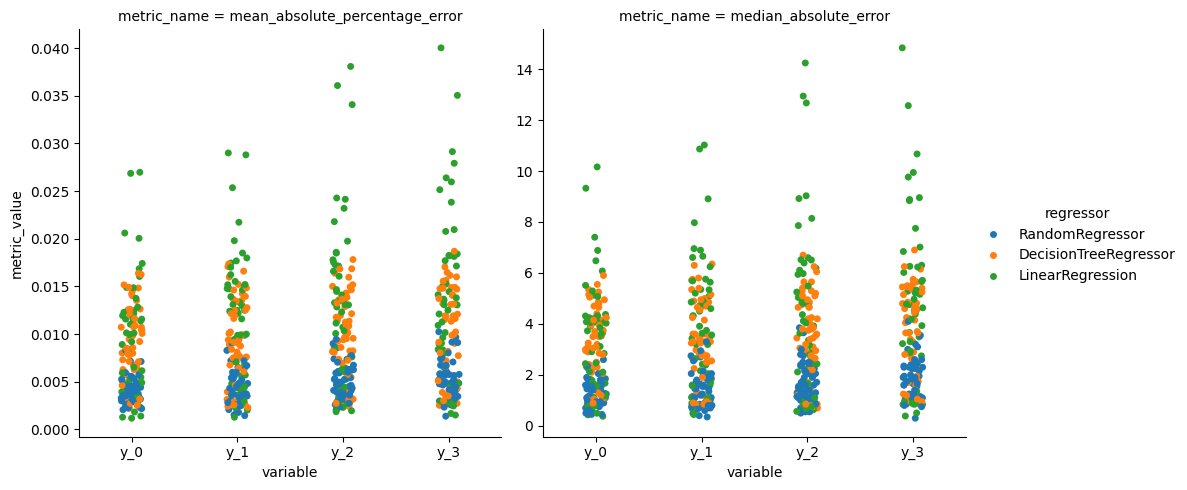

In [15]:
sns.catplot(data=pd.DataFrame(backtesting_results),
            x="variable", y="metric_value", hue="regressor", col="metric_name", sharey=False,)